### Importing Libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import os

import seaborn as sns

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

%run helpFunction.ipynb

\begin{table}
\caption{Test Klassifikations Metriken}
\label{tab:model_performance}
\begin{tabular}{llllr}
\toprule
Modell & Accuracy & Precision & Recall & F1-Score \\
\midrule
ViT & 83\% & 83\% & 83\% & 83.000000 \\
Hybridmodel - ViT - DeiT & 82\% & 82\% & 82\% & 82.000000 \\
Hybridmodel - ViT Lite - DeiT & 82\% & 82\% & 82\% & 82.000000 \\
InceptionV3 & 82\% & 83\% & 82\% & 82.000000 \\
DeiT & 81\% & 81\% & 82\% & 81.000000 \\
ViT Lite & 79\% & 79\% & 79\% & 79.000000 \\
Basic CNN & 78\% & 80\% & 78\% & 78.000000 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/rg/wpq9g3gn2_sg42m9vzpp7flw0000gn/T/ipykernel_6431/1995663629.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Modell').apply(lambda x: x.nlargest(1, 'F1-Score')).reset_index(drop=True)


In [2]:
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
wandb.init(project="VisionTransformer")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: silvan-wiedmer (silvan-wiedmer-fhgr). Use `wandb login --relogin` to force relogin


### Konfiguration Settings

In [4]:
image_size = (250, 250)
batch_size = 32

### Data Preprocessing

In [5]:
path_with_sign = '../data/y'
path_without_sign = '../data/n'

In [6]:
from image_preprocessors import apply_canny, apply_morphology, black_and_white

In [7]:
def load_images_from_folder(folder, label, target_size, type='normal'):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:             
            img = cv2.imread(img_path)
            if type == 'canny':
                img = apply_canny(img, image_size)
            elif type == 'morphology':
                img = apply_morphology(img, target_size)
            elif type == 'normal':
                img = black_and_white(img, target_size)
            else:    
                raise ValueError(f"Unbekannter Typ '{type}'")
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Fehler beim Laden des Bildes {img_path}: {e}")
    return np.array(images), np.array(labels)

In [8]:
images_with_sign_canny, labels_with_sign_canny = load_images_from_folder(path_with_sign, 0, image_size, type='canny')
images_without_sign_canny, labels_without_sign_canny = load_images_from_folder(path_without_sign, 1, image_size, type='canny')

images_with_sign_morphology, labels_with_sign_morphology = load_images_from_folder(path_with_sign, 0, image_size, type='morphology')
images_without_sign_morphology, labels_without_sign_morphology = load_images_from_folder(path_without_sign, 1, image_size, type='morphology')

images_with_sign_normal, labels_with_sign_normal = load_images_from_folder(path_with_sign, 0, image_size, type='normal')
images_without_sign_normal, labels_without_sign_normal = load_images_from_folder(path_without_sign, 1, image_size, type='normal')


images_with_sign_canny = np.array(images_with_sign_canny)
images_without_sign_canny = np.array(images_without_sign_canny)
images_with_sign_morphology = np.array(images_with_sign_morphology)
images_without_sign_morphology = np.array(images_without_sign_morphology)
images_with_sign_normal = np.array(images_with_sign_normal)
images_without_sign_normal = np.array(images_without_sign_normal)

images_with_sign = np.concatenate((images_with_sign_canny, images_with_sign_morphology, images_with_sign_normal), axis=-1)
images_without_sign = np.concatenate((images_without_sign_canny, images_without_sign_morphology, images_without_sign_normal), axis=-1)
labels_with_sign = np.array(labels_with_sign_canny)
labels_without_sign = np.array(labels_without_sign_canny)

all_images = np.concatenate((images_with_sign, images_without_sign), axis=0)
all_labels = np.concatenate((labels_with_sign, labels_without_sign), axis=0)

print("Shape of all_images tensor:", all_images.shape)
print("Shape of all_labels tensor:", all_labels.shape)

Shape of all_images tensor: (1456, 250, 250, 3)
Shape of all_labels tensor: (1456,)


### Data Normalization

In [9]:
all_images = all_images.astype('float32') / 255.0
all_images.shape

(1456, 250, 250, 3)

In [10]:
namelabels = {0: 'Wartelinie', 1: 'keine Wartelinie'}
def show_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(namelabels[label])
    plt.show()

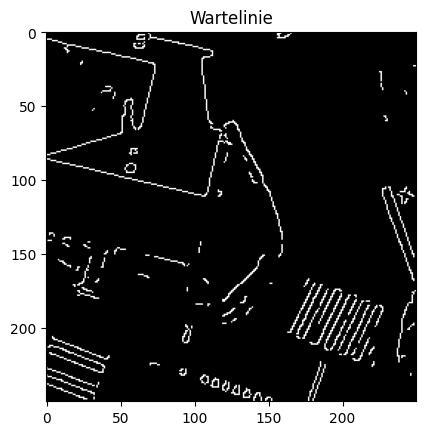

In [11]:
show_image(images_with_sign_canny[4], labels_with_sign_canny[4])

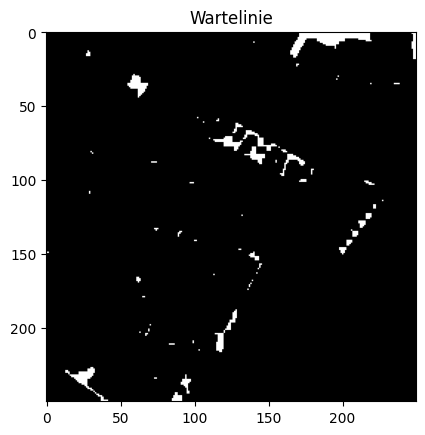

In [12]:
show_image(images_with_sign_morphology[3], labels_with_sign_morphology[3])

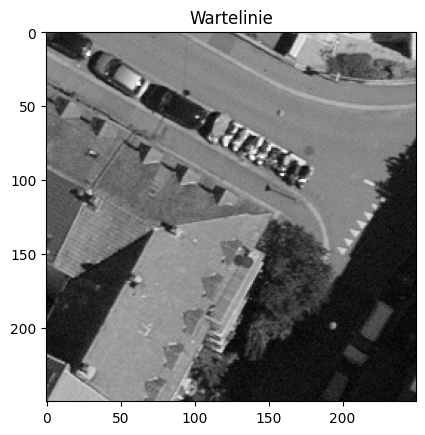

In [13]:
show_image(images_with_sign_normal[3], labels_with_sign_normal[3])

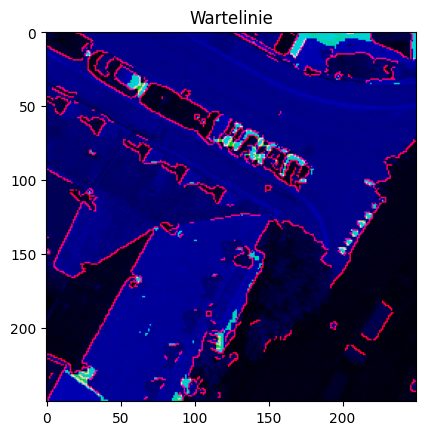

In [14]:
show_image(all_images[3], all_labels[3])

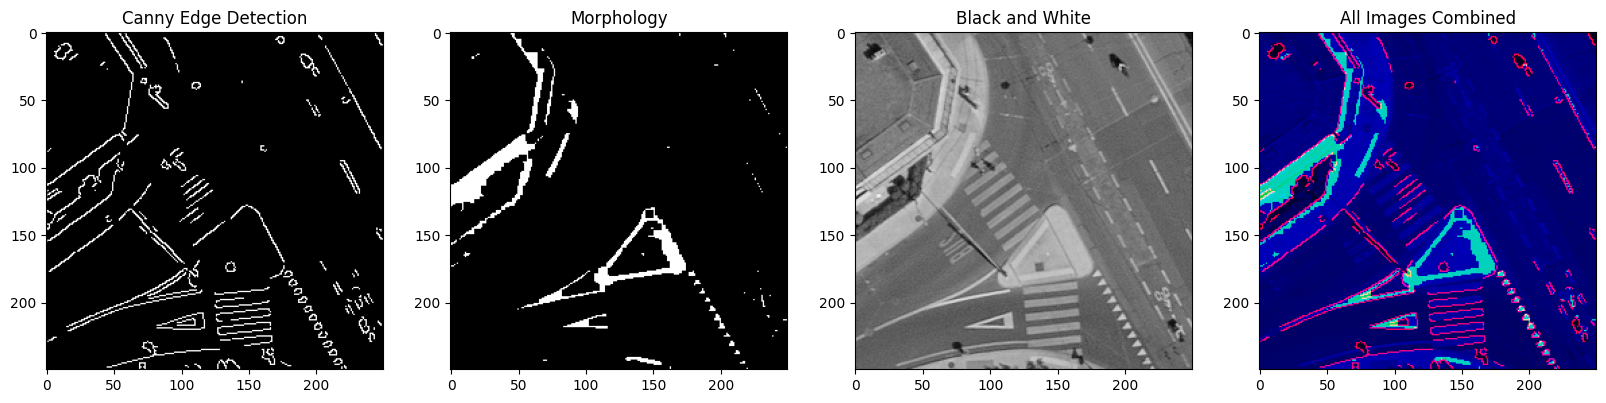

In [15]:

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(images_with_sign_canny[1], cmap='gray')
ax[0].set_title('Canny Edge Detection')

ax[1].imshow(images_with_sign_morphology[1], cmap='gray')
ax[1].set_title('Morphology')

ax[2].imshow(images_with_sign_normal[1], cmap='gray')
ax[2].set_title('Black and White')

ax[3].imshow(all_images[1], cmap='gray')
ax[3].set_title('All Images Combined')

plt.show()

### Data Splitting

In [16]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

In [17]:
train_images.shape, test_images.shape

((1164, 250, 250, 3), (292, 250, 250, 3))

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

In [19]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)

### Vortrainiertes Modell

In [20]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=None)
base_model.trainable = False

In [21]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x) 

In [22]:
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=20,
    validation_split=0.10,
    callbacks=[WandbMetricsLogger()]
)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 475ms/step - accuracy: 0.6060 - loss: 4.0292 - val_accuracy: 0.5470 - val_loss: 3.9928
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 448ms/step - accuracy: 0.7450 - loss: 3.7094 - val_accuracy: 0.6154 - val_loss: 3.9055
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.7658 - loss: 3.6205 - val_accuracy: 0.6752 - val_loss: 3.7741
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.8093 - loss: 3.5245 - val_accuracy: 0.6923 - val_loss: 3.6907
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 446ms/step - accuracy: 0.8322 - loss: 3.3998 - val_accuracy: 0.7179 - val_loss: 3.6064
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 452ms/step - accuracy: 0.8211 - loss: 3.3598 - val_accuracy: 0.7692 - val_loss: 3.4827
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.8298 - loss: 3.2807 - val_accuracy: 0.7692 - val_loss: 3.3960
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 448ms/step - accuracy: 0.8263 - loss: 3.2128 - val_accu

KeyboardInterrupt: 

In [25]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Testgenauigkeit: {test_acc:.4f}, Testverlust: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - accuracy: 0.8274 - loss: 3.0150
Testgenauigkeit: 0.8253, Testverlust: 3.0424


In [26]:
wandb.log({"test_loss": test_loss, "test_acc": test_acc})

NameError: name 'history' is not defined

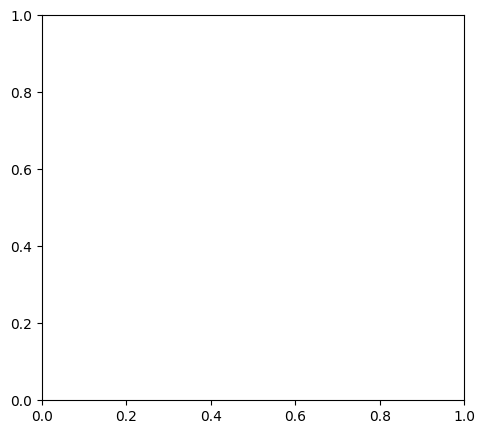

In [27]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.suptitle('Model Training - InceptionV3', fontsize=16)
plt.tight_layout()
plt.show()


In [28]:
predictions = model.predict(test_images)
predictions = (predictions > 0.5)

prediction_csv(test_labels, predictions, 'InceptionV3')

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 438ms/step
              precision    recall  f1-score     support
0              0.842857  0.802721  0.822300  147.000000
1              0.809211  0.848276  0.828283  145.000000
accuracy       0.825342  0.825342  0.825342    0.825342
macro avg      0.826034  0.825498  0.825291  292.000000
weighted avg   0.826149  0.825342  0.825271  292.000000
82.53424657534246
        Modell Accuracy Precision Recall F1-Score                       Date
0  InceptionV3      83%       83%    83%      83% 2024-10-27 20:00:53.036870


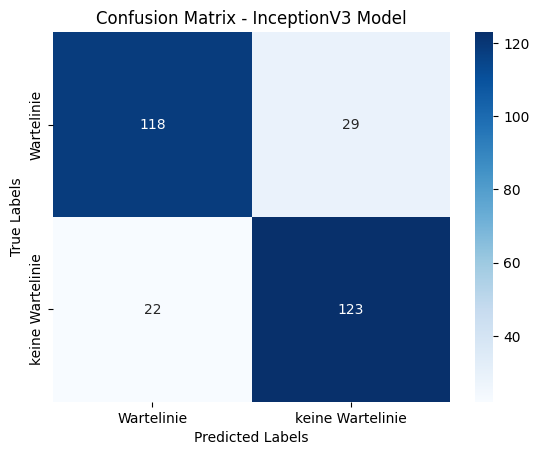

In [29]:
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=namelabels.values(), yticklabels=namelabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - InceptionV3 Model')
wandb.log({"confusion-matrix": wandb.Image(plt)})
plt.show()

In [30]:
wandb.finish()

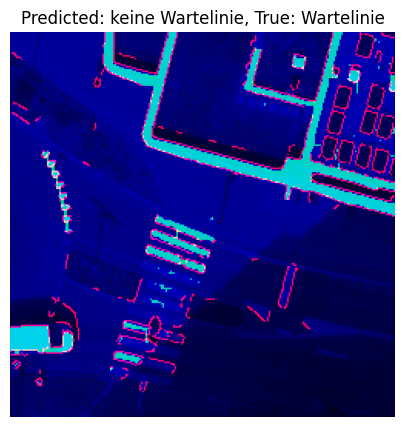

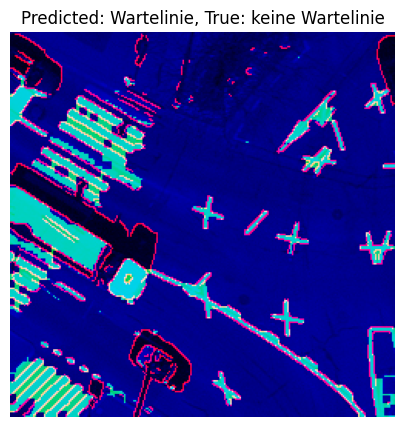

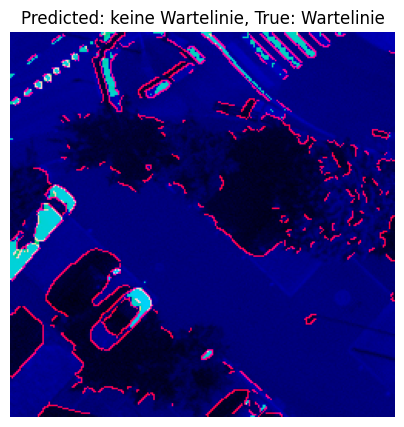

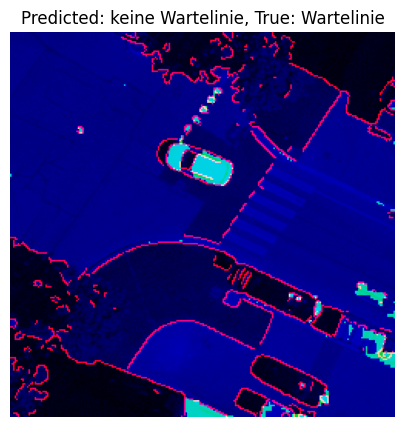

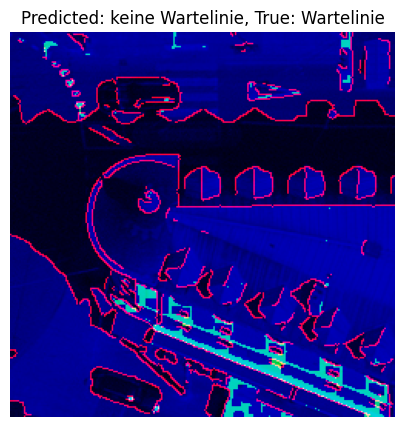

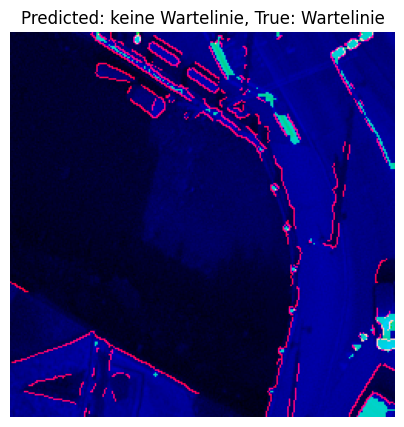

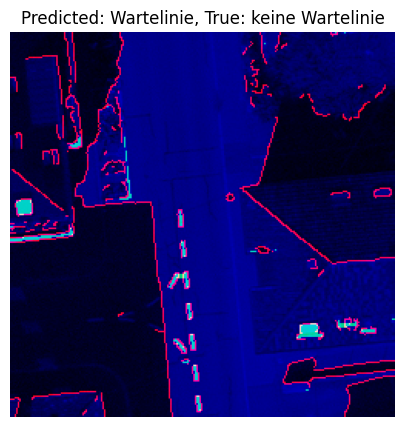

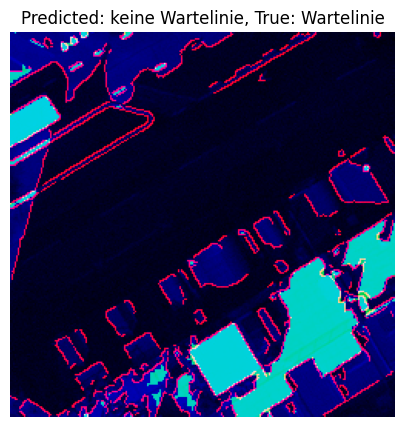

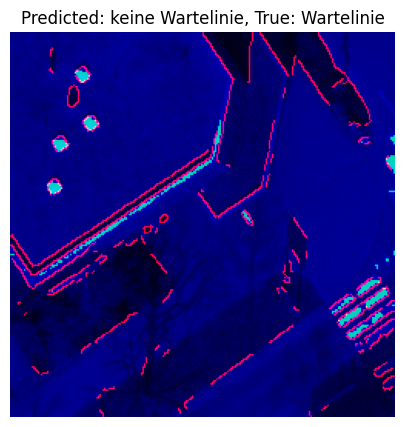

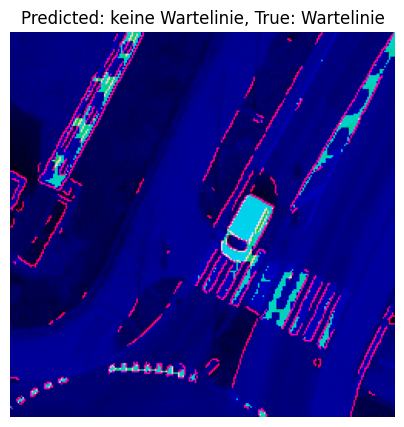

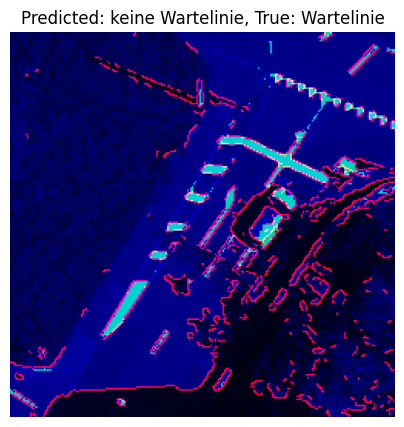

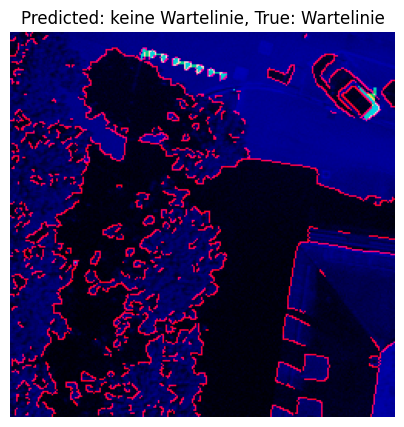

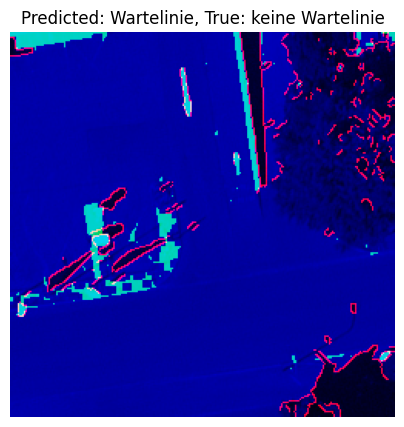

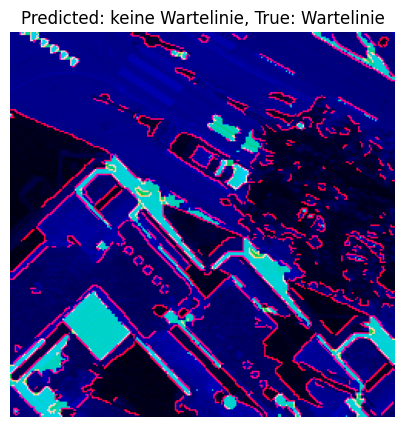

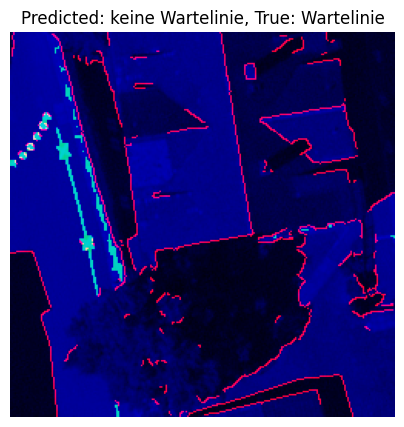

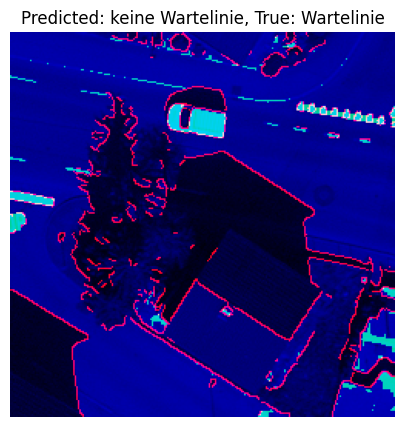

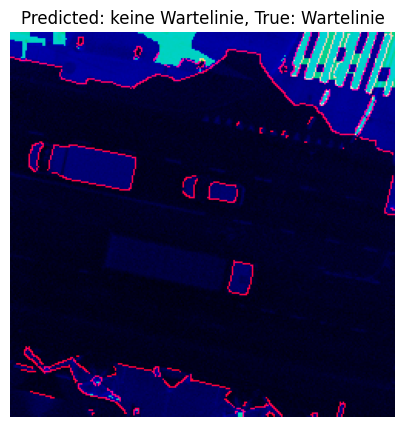

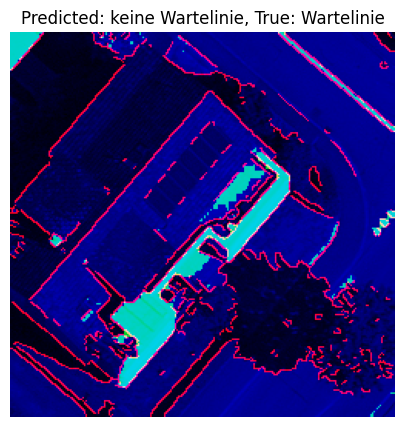

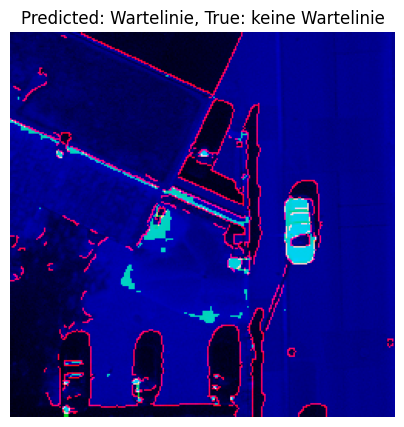

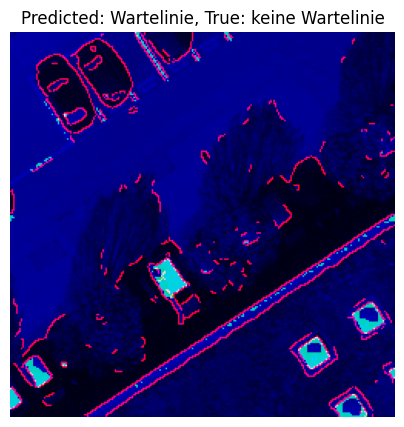

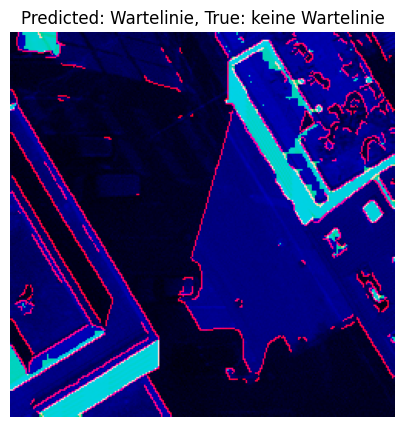

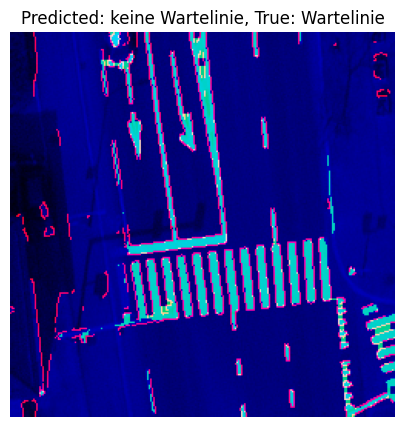

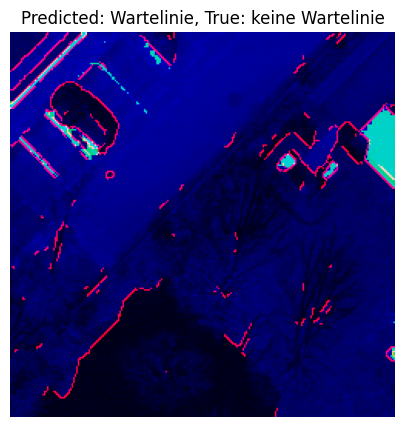

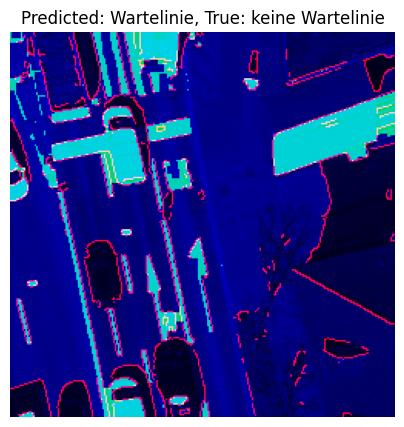

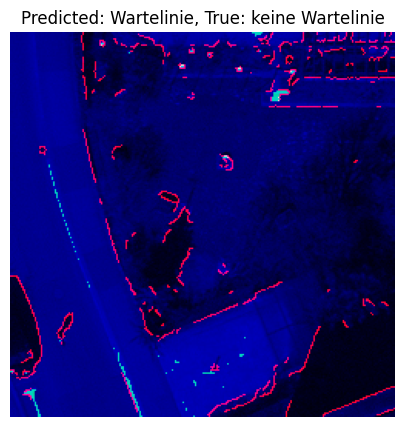

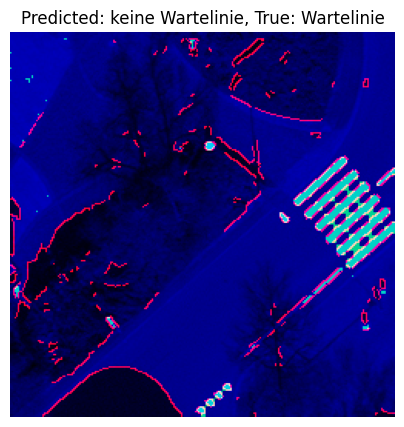

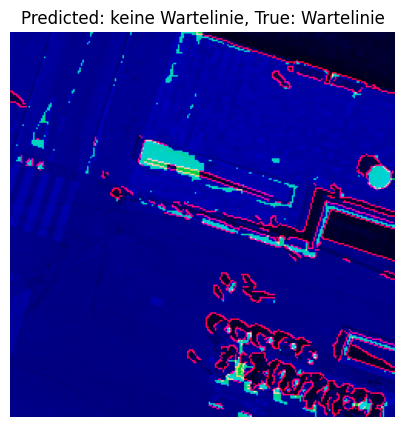

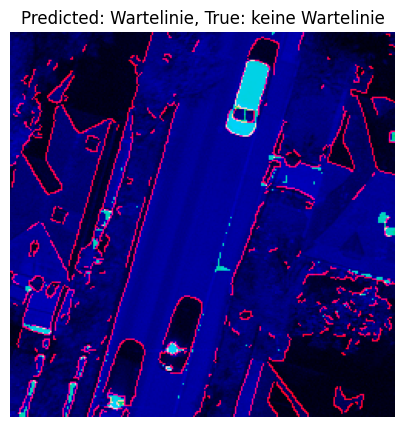

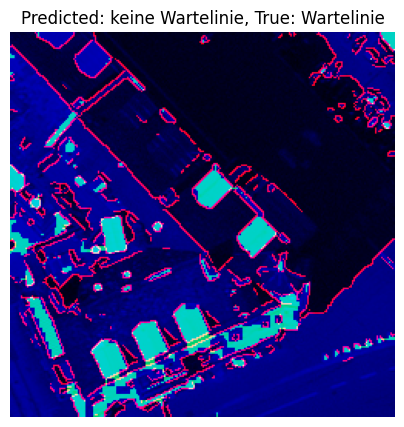

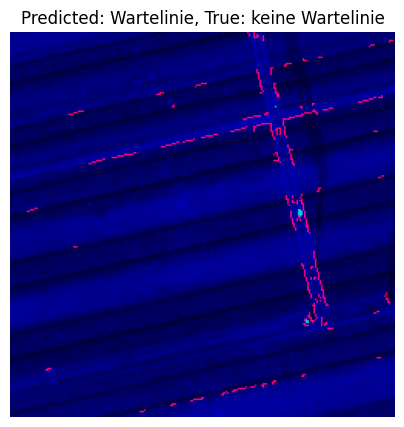

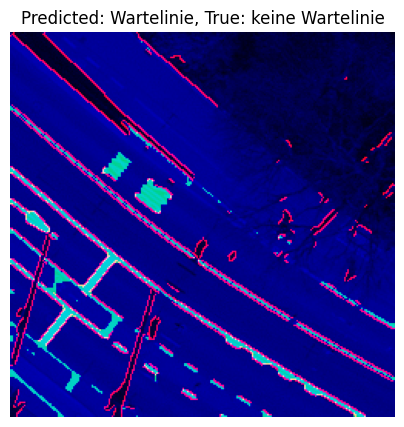

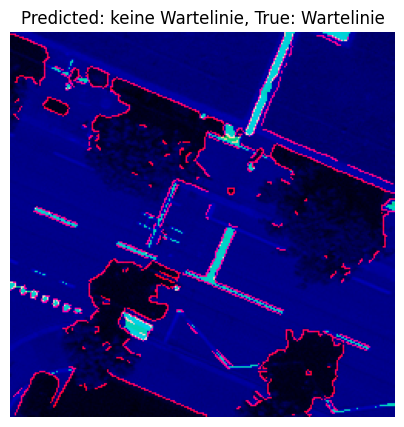

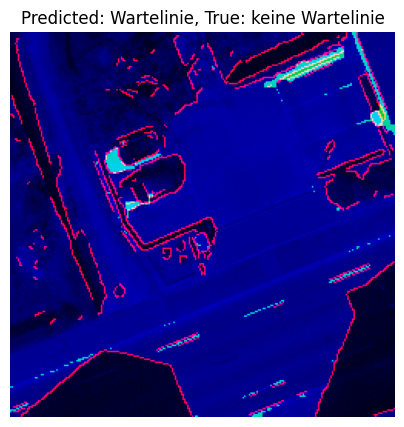

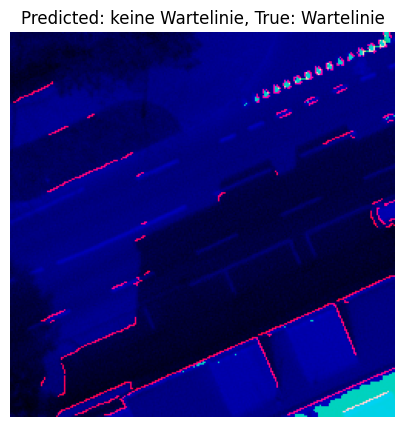

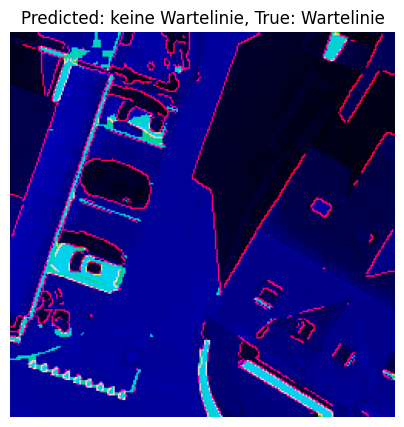

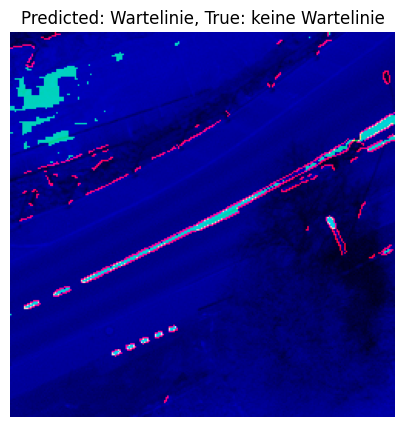

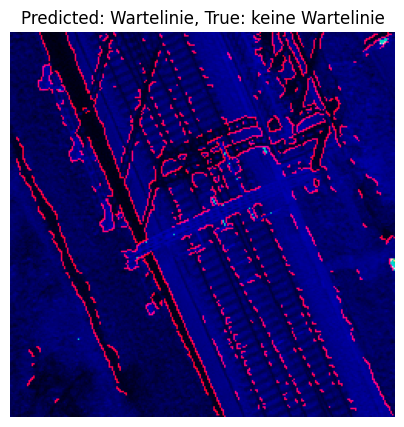

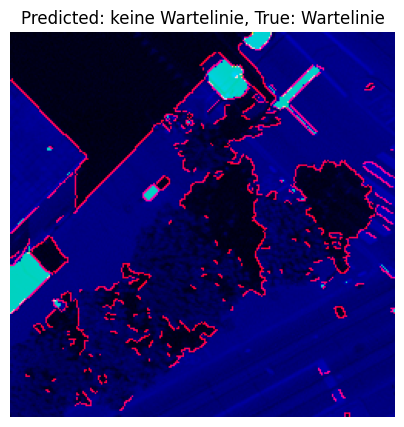

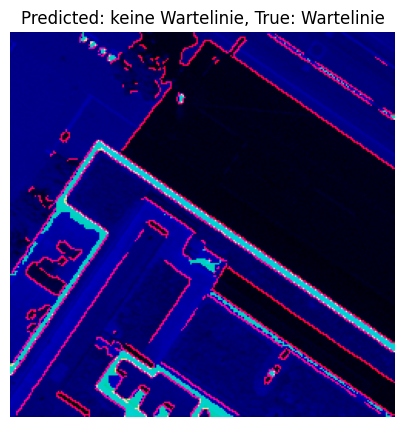

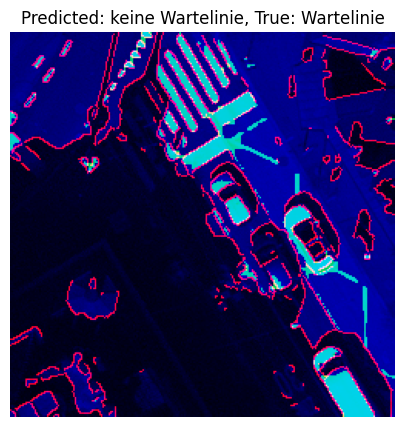

In [31]:
predictions_class_indices = (predictions.flatten() > 0.5).astype(int)

test_labels_class_indices = test_labels.flatten().astype(int)

incorrect_indices = [i for i, (true, pred) in enumerate(zip(test_labels_class_indices, predictions_class_indices)) if true != pred]

max_images_to_show = 40
shown_images = 0

for i in incorrect_indices:
    if shown_images < max_images_to_show:
        plt.figure(figsize=(5,5))
        plt.imshow(test_images[i], cmap='gray' if test_images[i].ndim == 2 else None)

        predicted_label = namelabels.get(predictions_class_indices[i], "Unknown")
        true_label = namelabels.get(test_labels_class_indices[i], "Unknown")
        plt.title(f'Predicted: {predicted_label}, True: {true_label}')
        plt.axis('off')
        plt.show()
        shown_images += 1
    else:
        break